<!--NOTEBOOK_HEADER-->
*This notebook contains material from [PyRosetta](https://RosettaCommons.github.io/PyRosetta.notebooks);
content is available [on Github](https://github.com/RosettaCommons/PyRosetta.notebooks.git).*

<!--NAVIGATION-->
< [Distributed analysis example: exhaustive ddG PSSM](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/16.01-PyData-ddG-pssm.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Example of Using PyRosetta with GNU Parallel](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/16.03-GNU-Parallel-Via-Slurm.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/16.02-PyData-miniprotein-design.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# Distributed computation example: miniprotein design

## Notes
This tutorial will walk you through how to design miniproteins in PyRosetta using the PyData stack for analysis and distributed computing.

This Jupyter notebook uses parallelization and is not meant to be executed within a Google Colab environment.

## Setup
Please see setup instructions in Chapter 16.00

## Citation
[Integration of the Rosetta Suite with the Python Software Stack via reproducible packaging and core programming interfaces for distributed simulation](https://doi.org/10.1002/pro.3721)

Alexander S. Ford, Brian D. Weitzner, Christopher D. Bahl

## Manual
Documentation for the `pyrosetta.distributed` namespace can be found here: https://nbviewer.jupyter.org/github/proteininnovation/Rosetta-PyData_Integration/blob/master/distributed_overview.ipynb

In [1]:
import sys
if 'google.colab' in sys.modules:
    print("This Jupyter notebook uses parallelization and is therefore not set up for the Google Colab environment.")
    sys.exit(0)

In [2]:
import pyrosetta
import dask.bag
import dask.distributed

In [3]:
import pandas
import seaborn
from matplotlib import pylab

In [4]:
from pyrosetta.distributed.tasks.score import ScorePoseTask
from pyrosetta.distributed.io import pose_from_pdbstring
from pyrosetta.distributed.packed_pose import to_dict

In [5]:
import zipfile

# Init

Setup LocalCluster to full utilize the current machine.

In [6]:
cluster = dask.distributed.LocalCluster(n_workers=1, threads_per_worker=1)
client = dask.distributed.Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:60557,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


# Load 

Load decoys from batch compute run, adding annotations for designed sequence, cystine count and cystine location.

In [7]:
def load_source(decoy):
    src_pdb = zipfile.ZipFile(library).open(decoy).read()
    p = pose_from_pdbstring(src_pdb)
    
    cys_locations=[i for i, c in enumerate(p.pose.sequence()) if c == "C"]
    p = p.update_scores(
        library=library,
        decoy=decoy,
        sequence=p.pose.sequence(),
        num_res = len(p.pose.sequence()),
        num_cys=len(cys_locations),
        cys_locations=",".join(map(str, cys_locations))
    )

    return p

In [9]:
library = "inputs/EHEE_library.zip"
decoy_names = [f.filename for f in zipfile.ZipFile(library).filelist if f.filename.endswith(".pdb")]

In [10]:
decoys = dask.bag.from_sequence(decoy_names).map(load_source).map(ScorePoseTask()).persist()

In [12]:
if not os.getenv("DEBUG"):
    result_frame = pandas.DataFrame.from_records(decoys.map(to_dict).compute()).sort_values("total_score")

# Analysis

We anticipate a distribution of score results, with higher scores with more disulfide insertions.

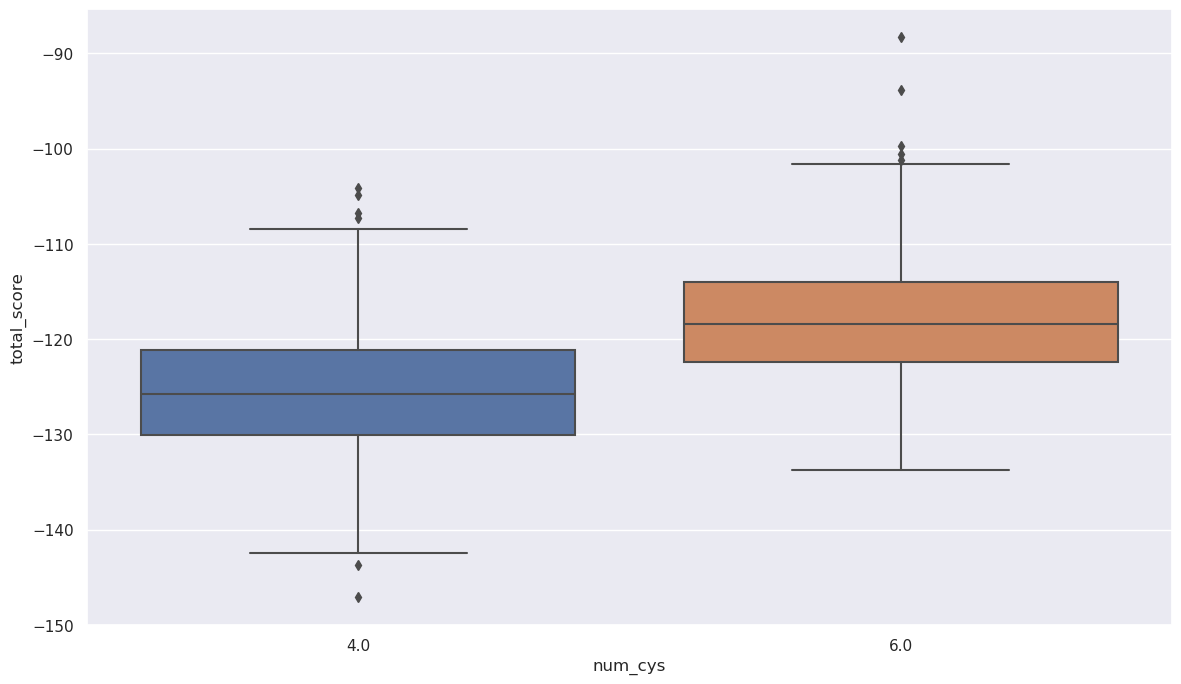

In [11]:
if not os.getenv("DEBUG"):
    seaborn.boxplot(x="num_cys", y="total_score", data=result_frame)

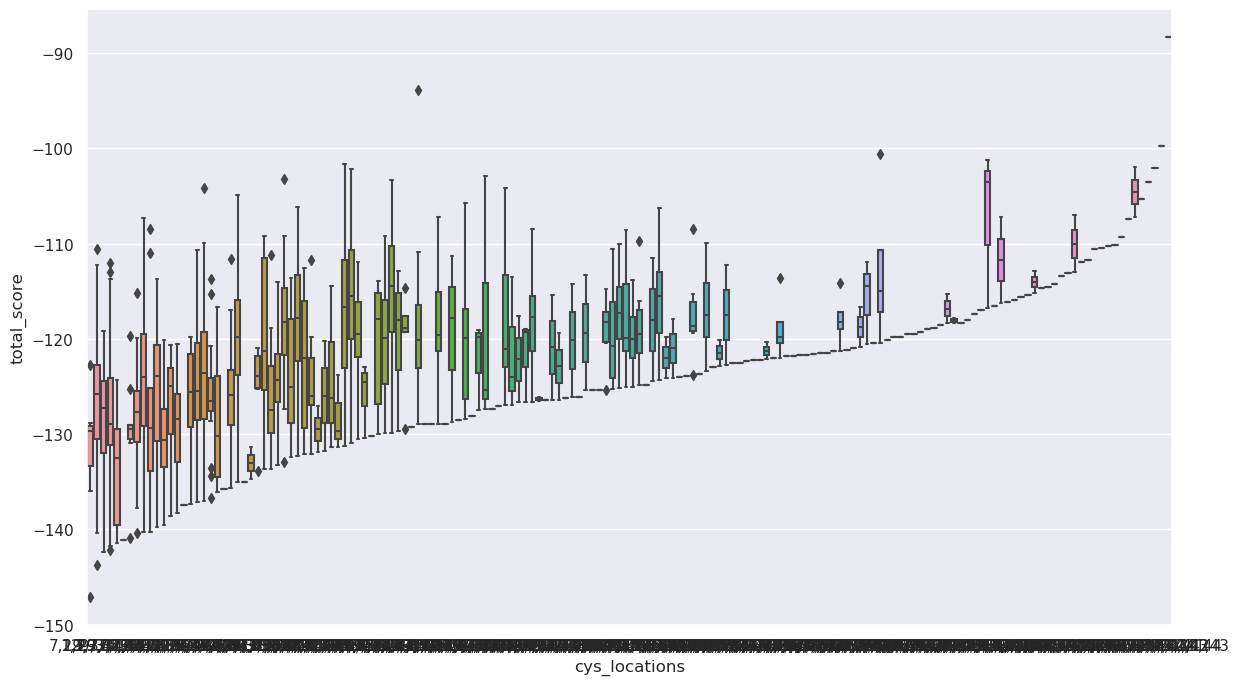

In [12]:
if not os.getenv("DEBUG"):
    seaborn.boxplot(x="cys_locations", y="total_score", data=result_frame)

# Select 

Select the best model by total_Score for each inserted disulfide location, allowing us to test a variety of disulfide architectures.

In [13]:
if not os.getenv("DEBUG"):
    best_by_location = to_dict(result_frame.groupby("cys_locations").head(1).reset_index(drop=True))
    print(len(best_by_location))

In [14]:
if not os.getenv("DEBUG"):
    with open("EHEE.best_by_location.fasta", "w") as out:
        for entry in best_by_location:
            print(f">{entry['decoy']}", file=out)
            print(entry['sequence'], file=out)

In [13]:
!head expected_outputs/EHEE.best_by_location.fasta

>30652025_EHEE_254_0001.pdb
GDYQLHTCNTSEEELKKLTETLRRRLQTECKLERHGDCYTITCHV
>30887334_EHEE_738_0001.pdb
GCKTLTFCGYDDEQAKKIQKDISKTVQRPVEVHKHGSCWEFHVCV
>30856927_EHEE_395_0001.pdb
GCTTWEFHNVDPNEVKKALRELSEKTGAECHLEQHGNTFHITCCV
>30884953_EHEE_269_0001_0004.pdb
GQKCVTFCGQDPREVKKIAEEIARRLQVPYEIRRHGSCITVCFKV
>30696637_EHEE_467_0001_0002.pdb
GTKTFTYDGVDPTEVDKSRERLEKELKTRCELECRGNQCHIHCHV


# Visualize 

Visualize using Py3Dmol or PyMolMover as you have learned before. 

In [1]:
'''
import py3Dmol
view = py3Dmol.view(viewergrid=(3, 3), linked=False, width=900, height=900)
for i in range(9):
    view.addModel( pyrosetta.distributed.io.to_pdbstring(best_by_location[i]), "pdb", viewer=(i/3, i%3),)
    
view.setStyle({'cartoon':{'color':'spectrum'}})
view.setStyle({"resn": "CYS"}, {'stick': {}, 'cartoon':{'color':'spectrum'}} )
view.zoomTo()
'''

'\nimport py3Dmol\nview = py3Dmol.view(viewergrid=(3, 3), linked=False, width=900, height=900)\nfor i in range(9):\n    view.addModel( pyrosetta.distributed.io.to_pdbstring(best_by_location[i]), "pdb", viewer=(i/3, i%3),)\n    \nview.setStyle({\'cartoon\':{\'color\':\'spectrum\'}})\nview.setStyle({"resn": "CYS"}, {\'stick\': {}, \'cartoon\':{\'color\':\'spectrum\'}} )\nview.zoomTo()\n'

<!--NAVIGATION-->
< [Distributed analysis example: exhaustive ddG PSSM](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/16.01-PyData-ddG-pssm.ipynb) | [Contents](toc.ipynb) | [Index](index.ipynb) | [Example of Using PyRosetta with GNU Parallel](http://nbviewer.jupyter.org/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/16.03-GNU-Parallel-Via-Slurm.ipynb) ><p><a href="https://colab.research.google.com/github/RosettaCommons/PyRosetta.notebooks/blob/master/notebooks/16.02-PyData-miniprotein-design.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>